# Fake Image Detection 

## Importing Labraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [2]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

## Making Dataset

In [3]:
REAL = sorted(os.listdir('E:/Summer 2020 Project/casia-dataset/CASIA2/REAL/'))

FAKE= sorted(os.listdir('E:/Summer 2020 Project/casia-dataset/CASIA2/FAKE/'))

a=[]
for i in REAL:
    a.append(0)
b=[]
for i in FAKE:
    b.append(1)

data=REAL+FAKE

number=a+b

df = pd.DataFrame()
path="E:/Summer 2020 Project/casia-dataset/CASIA2/COMMON/"
df['images']=[path+str(x) for x in data]
df['labels']=[ x for x in number]

df.to_csv('E:\\Summer 2020 Project\\FakeImageDetector-master\\dataset.csv',index=False)

print(df)

                                                  images  labels
0      E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       0
1      E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       0
2      E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       0
3      E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       0
4      E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       0
...                                                  ...     ...
20104  E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       1
20105  E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       1
20106  E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       1
20107  E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       1
20108  E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       1

[20109 rows x 2 columns]


## Convert to Error Level Analysis

In [4]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

In [5]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ELA_filename = filename.split('.')[0] + '.ela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

## Comparison of Real and Fake image( fake images in ELA form)

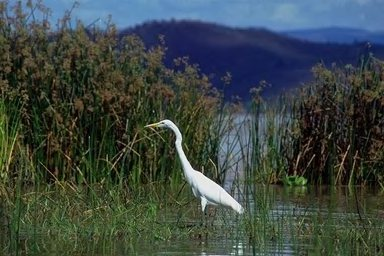

In [6]:
Image.open('E:\Summer 2020 Project\casia-dataset\CASIA2\REAL\Au_ani_00002.jpg')

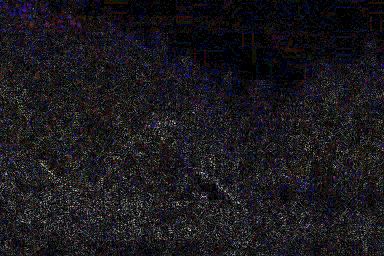

In [7]:
convert_to_ela_image('E:\Summer 2020 Project\casia-dataset\CASIA2\REAL\Au_ani_00002.jpg', 90)

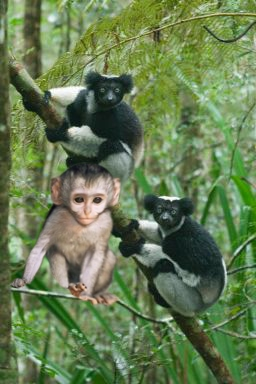

In [8]:
Image.open('E:\Summer 2020 Project\casia-dataset\CASIA2\FAKE\Fake 0004.jpg')

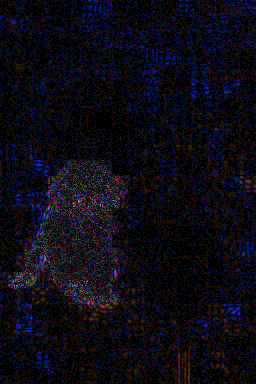

In [9]:
convert_to_ela_image('E:\Summer 2020 Project\casia-dataset\CASIA2\FAKE\Fake 0004.jpg', 90)

## Data preparation

### Read dataset and conversion to ELA

In [10]:
dataset = pd.read_csv('E:\\Summer 2020 Project\\FakeImageDetector-master\\dataset.csv')
print(dataset)

                                                  images  labels
0      E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       0
1      E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       0
2      E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       0
3      E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       0
4      E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       0
...                                                  ...     ...
20104  E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       1
20105  E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       1
20106  E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       1
20107  E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       1
20108  E:/Summer 2020 Project/casia-dataset/CASIA2/CO...       1

[20109 rows x 2 columns]


In [11]:
X = []
Y = []

In [12]:
for index, row in dataset.iterrows():
    X.append(array(convert_to_ela_image(row[0], 90).resize((128, 128))).flatten() / 255.0)
    Y.append(row[1])

E:\Summer 2020 Project\FakeImageDetector-master\venv\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
E:\Summer 2020 Project\FakeImageDetector-master\venv\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


In [13]:
X

In [14]:
X = X.reshape(-1, 128, 128, 3)

array([[0.05882353, 0.02745098, 0.14117647, ..., 0.01960784, 0.01960784,
        0.02745098],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.11764706, 0.11764706, 0.30980392, ..., 0.09803922, 0.10980392,
        0.07058824],
       ...,
       [0.00784314, 0.00784314, 0.02745098, ..., 0.01960784, 0.01960784,
        0.02352941],
       [0.10196078, 0.1254902 , 0.10196078, ..., 0.        , 0.        ,
        0.        ],
       [0.01176471, 0.01176471, 0.01176471, ..., 0.11372549, 0.11764706,
        0.09411765]])

In [15]:
X

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

array([[[[0.05882353, 0.02745098, 0.14117647],
         [0.01960784, 0.04705882, 0.06666667],
         [0.05882353, 0.05882353, 0.04313725],
         ...,
         [0.00784314, 0.00784314, 0.00784314],
         [0.03137255, 0.03137255, 0.00784314],
         [0.06666667, 0.06666667, 0.        ]],

        [[0.03529412, 0.04313725, 0.10588235],
         [0.00392157, 0.00392157, 0.01960784],
         [0.02745098, 0.02745098, 0.02745098],
         ...,
         [0.00784314, 0.01176471, 0.01176471],
         [0.01568627, 0.01568627, 0.01176471],
         [0.00784314, 0.00784314, 0.00392157]],

        [[0.03921569, 0.04313725, 0.07058824],
         [0.01568627, 0.00392157, 0.1254902 ],
         [0.05098039, 0.01176471, 0.09019608],
         ...,
         [0.01176471, 0.01176471, 0.01176471],
         [0.02352941, 0.02745098, 0.02745098],
         [0.03137255, 0.03137255, 0.01176471]],

        ...,

        [[0.03529412, 0.03137255, 0.03921569],
         [0.05490196, 0.05882353, 0.05882353]

## CNN building

In [17]:

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
print("Input: ", model.input_shape)


model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))


model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))#for overfitting


model.add(Flatten())#for imput of dense
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))
print("Output: ", model.output_shape)

In [18]:
model.summary()

Input:  (None, 128, 128, 3)
Output:  (None, 2)


## TO REMOVE DIMINISHING GRADIENT WE USE OPTIMISER VV IMP

In [19]:
optimizer = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)


In [20]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


### Define early stopping ( if the output is coming same stop early)

In [21]:
early_stopping = EarlyStopping(monitor='val_acc',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

### Model training

In [22]:
epochs = 9
batch_size = 100

In [23]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_val, Y_val), verbose = 2, callbacks=[early_stopping])

## Performance measure

### Accuracy and loss curves during training-validation

In [24]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)